In [18]:
from datasets import load_dataset
from huggingface_hub import login
import os
from dotenv import load_dotenv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print('tf.__version__:', tf.__version__)
print('GPUs:', len(tf.config.list_physical_devices('GPU')))
load_dotenv()

tf.__version__: 2.20.0
GPUs: 0


True

In [19]:
login(token=os.getenv("HF_TOKEN"))
ds = load_dataset("shivamsark/div2k")
type(ds)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


datasets.dataset_dict.DatasetDict

In [20]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1280
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 320
    })
})

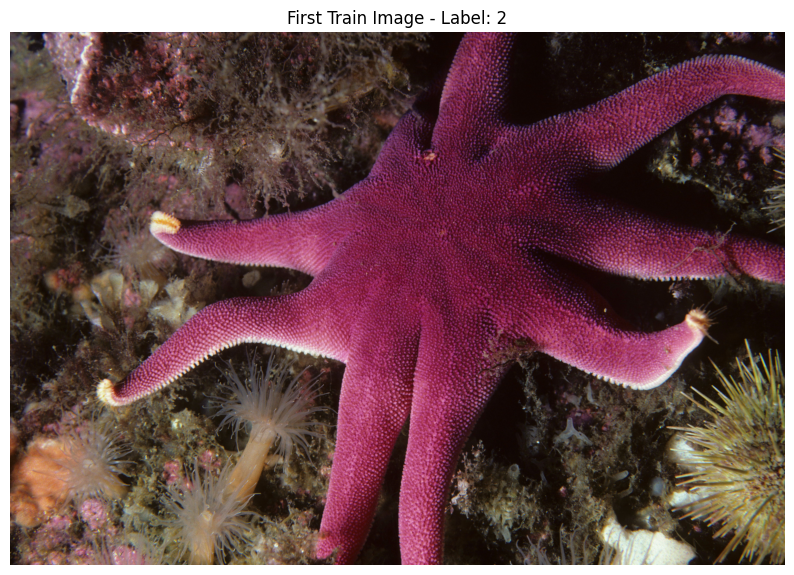

Image size: (2040, 1404)
Image mode: RGB


In [21]:
import matplotlib.pyplot as plt

# Get the first train image
first_image = ds['train'][0]['image']

# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(first_image)
plt.axis('off')
plt.title(f"First Train Image - Label: {ds['train'][0]['label']}")
plt.show()

# Print image info
print(f"Image size: {first_image.size}")
print(f"Image mode: {first_image.mode}")

In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf

def prepare_dataset(hf_dataset, scale=2):
    """
    Convert HuggingFace dataset to tf.data.Dataset with (LR, HR) pairs.
    
    This function crops the HR image to be divisible by the scale factor
    to prevent dimension mismatches.
    """
    def generator():
        for example in hf_dataset:
            # Load the original high-resolution image
            hr_pil = example['image']
            
            # Crop HR image to be a multiple of the scale factor
            w, h = hr_pil.size
            w_new = w - (w % scale)
            h_new = h - (h % scale)
            # Crop from top-left corner (0, 0, w_new, h_new)
            hr_pil_cropped = hr_pil.crop((0, 0, w_new, h_new))
            
            # --- Create LR Image ---
            lr_size = (w_new // scale, h_new // scale)
            lr_pil = hr_pil_cropped.resize(lr_size, Image.BICUBIC)
            
            # --- Convert to Tensors and Normalize ---
            hr_image = np.array(hr_pil_cropped, dtype=np.float32) / 255.0
            lr_image = np.array(lr_pil, dtype=np.float32) / 255.0
            
            yield lr_image, hr_image
    
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32)
        )
    ).batch(1).prefetch(tf.data.AUTOTUNE)

# Split train data into train (90%) and validation (10%)
train_val_split = ds['train'].train_test_split(test_size=0.1, seed=42)

# Re-create the datasets with the fixed function
train_dataset = prepare_dataset(train_val_split['train'])
val_dataset = prepare_dataset(train_val_split['test'])
test_dataset = prepare_dataset(ds['test'])

print("Fixed Datasets created:")
print(f"train_dataset: {train_dataset}")
print(f"val_dataset: {val_dataset}")
print(f"test_dataset: {test_dataset}")

Fixed Datasets created:
train_dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None))>
val_dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None))>
test_dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None))>


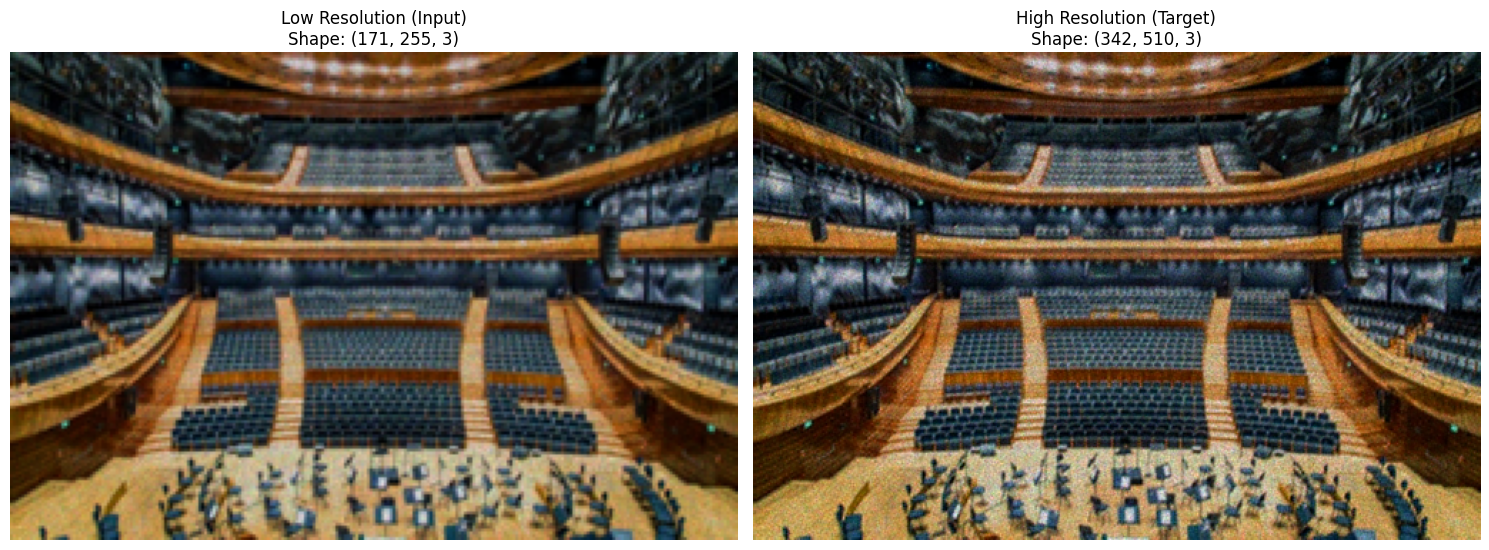

LR Image min/max: 0.00 / 0.93
HR Image min/max: 0.00 / 1.00


2025-11-13 15:20:03.171199: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
# Display the first training image (LR and HR side by side)
import matplotlib.pyplot as plt

# Get one batch from the dataset
for lr_batch, hr_batch in train_dataset.take(1):
    # Get the first (and only) image from the batch
    lr_image = lr_batch[0] 
    hr_image = hr_batch[0]

    # --- Plotting ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Display LR image
    axes[0].imshow(lr_image)
    axes[0].set_title(f'Low Resolution (Input)\nShape: {lr_image.shape}')
    axes[0].axis('off')

    # Display HR image
    axes[1].imshow(hr_image)
    axes[1].set_title(f'High Resolution (Target)\nShape: {hr_image.shape}')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    
    print(f"LR Image min/max: {lr_image.numpy().min():.2f} / {lr_image.numpy().max():.2f}")
    print(f"HR Image min/max: {hr_image.numpy().min():.2f} / {hr_image.numpy().max():.2f}")

In [ ]:
import numpy as np

# This function will be applied to each example
def get_dimensions(example):
    """Gets the dimensions of the PIL image and adds them as new features."""
    size = example['image'].size
    example['width'] = size[0]
    example['height'] = size[1]
    return example

print("Calculating statistics (this may take a minute the first time)...")

# Use .map() to apply the function. This is fast and caches the results!
# num_proc=4 uses multiple cores to speed it up.
train_stats_ds = train_val_split['train'].map(get_dimensions, num_proc=4)

print("Calculation complete. Extracting stats...")

# Now, we just read the pre-computed lists (this is instant)
hr_heights = train_stats_ds['height']
hr_widths = train_stats_ds['width']

# Approximate LR stats (this is fast)
lr_widths_approx = [(w - (w % 2)) // 2 for w in hr_widths]
lr_heights_approx = [(h - (h % 2)) // 2 for h in hr_heights]

print("HIGH RESOLUTION (HR) Training Data Statistics:")
print("=" * 50)
print(f"  Median Height: {np.percentile(hr_heights, 50):.0f}")
print(f"  Median Width:  {np.percentile(hr_widths, 50):.0f}")
print(f"  Min/Max Height: {np.min(hr_heights)} / {np.max(hr_heights)}")
print(f"  Min/Max Width:  {np.min(hr_widths)} / {np.max(hr_widths)}")

print("\n" + "=" * 50)
print("LOW RESOLUTION (LR) Approximate Training Data Statistics:")
print("=" * 50)
print(f"  Median Height: {np.percentile(lr_heights_approx, 50):.0f}")
print(f"  Median Width:  {np.percentile(lr_widths_approx, 50):.0f}")
print(f"  Min/Max Height: {np.min(lr_heights_approx)} / {np.max(lr_heights_approx)}")
print(f"  Min/Max Width:  {np.min(lr_widths_approx)} / {np.max(lr_widths_approx)}")
print("\n" + "=" * 50)

Calculating statistics (this may take a minute the first time)...


Map (num_proc=4): 100%|██████████| 1152/1152 [00:18<00:00, 62.40 examples/s]


Calculation complete. Extracting stats...
HIGH RESOLUTION (HR) Training Data Statistics:
  Median Height: 510
  Median Width:  510
  Min/Max Height: 162 / 2040
  Min/Max Width:  279 / 2040

LOW RESOLUTION (LR) Approximate Training Data Statistics:
  Median Height: 255
  Median Width:  255
  Min/Max Height: 81 / 1020
  Min/Max Width:  139 / 1020



In [25]:
# Create super-resolution model
def create_model():
    model = keras.Sequential([
        layers.Input(shape=(None, None, 3)),
        layers.Conv2DTranspose(
            filters=3,
            kernel_size=4,
            strides=2,
            padding='same',
            activation='sigmoid'
        )
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = create_model()
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_3              │ (None, None, None, 3)  │           147 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147 (588.00 B)

 Trainable params: 147 (588.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Calculate the number of batches (steps)
# Since batch size is 1, steps = number of images
num_train_steps = len(train_val_split['train'])
num_val_steps = len(train_val_split['test'])

print(f"Training steps per epoch: {num_train_steps}")
print(f"Validation steps per epoch: {num_val_steps}")

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    steps_per_epoch=num_train_steps,  
    validation_steps=num_val_steps   
)

Training steps per epoch: 1152
Validation steps per epoch: 128
Epoch 1/5
 405/1152 ━━━━━━━━━━━━━━━━━━━━ 2:30 201ms/step - loss: 0.0182 - mae: 0.1139

KeyboardInterrupt: 

In [ ]:
# Calculate the number of test batches
# Since batch size is 1, steps = number of images
num_test_steps = len(ds['test'])

print(f"Test steps: {num_test_steps}")
print("Evaluating model on the test set...")
loss, mae = model.evaluate(
    test_dataset,
    steps=num_test_steps
)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

Test steps: 320
Evaluating model on the test set...
 70/320 ━━━━━━━━━━━━━━━━━━━━ 56s 227ms/step - loss: 0.0170 - mae: 0.1106

KeyboardInterrupt: 